
# A Notebook to TreatGeoSelf to easy access gridded climate time series data (Case study:  the Sauk-Suiattle Watershed )
<img src= "http://www.sauk-suiattle.com/images/Elliott.jpg"
style="float:left;width:150px;padding:20px">   
This data is compiled to digitally observe the Sauk-Suiattle Watershed, powered by HydroShare. <br />
<br />
Use this Jupyter Notebook to: <br /> 
Generate a list of available gridded data points in your area of interest, <br /> 
Download Livneh daily 1/16 degree gridded climate data, <br /> 
Download WRF daily 1/16 degree gridded climate data, <br /> 
Compare daily, monthly, and annual temperature and precipitation data. <br /> 
Visualize modeled streamflow results relative to the forcing data and observed streamflow. <br /> 
<br /> <br /> <br /> <img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:120px;padding:20px">  
#### A Watershed Dynamics Model by the Watershed Dynamics Research Group in the Civil and Environmental Engineering Department at the University of Washington 

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

If the python library fiona is not installed, please run the following lines in terminal, and choose 'y' when prompted. <br/>
conda install -c conda-forge fiona <br>
pip install fiona

In [1]:
# conda install -c conda-forge basemap-data-hires --yes
# conda install -c conda-forge basemap-data-hires graphviz python-graphviz pydot networkx rdflib --yes

# data processing
import os
import pandas as pd, numpy as np, dask, json
from utilities import hydroshare
import ogh

# plotting and shape libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# spatial plotting
import fiona
import shapely.ops
from shapely.geometry import MultiPolygon, shape, point, box, Polygon
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# domain='192.12.137.7'
# subdomain='/pub/dcp/archive/OBS/livneh2014.1_16deg/ascii/daily'

# row=dict()
# row['LAT'] = -120.00000
# loci='VIC_fluxes_Livneh_CONUSExt_v.1.2_2013_25.90625_-97.40625.bz2'

# print('/'.join(['ftp://'+domain+subdomain,'latitude.'+str(row['LAT']),loci+'.bz2']))

# print(os.path.join('ftp://'+domain+subdomain,'latitude.'+str(row['LAT']),loci+'.bz2'))

In [3]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

In [4]:
sorted(meta_file['dailymet_livneh2013'].keys())

['decision_steps',
 'delimiter',
 'domain',
 'end_date',
 'file_format',
 'filename_structure',
 'reference',
 'spatial_resolution',
 'start_date',
 'subdomain',
 'temporal_resolution',
 'variable_info',
 'variable_list',
 'web_protocol']

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [5]:
hs=hydroshare.hydroshare()
homedir = hs.getContentPath(os.environ["HS_RES_ID"])

homedir = '/home/jovyan/work/Observatory-1/ogh'
print('Data will be loaded from and save to:'+homedir)

Adding the following system variables:
   HS_USR_NAME = jphuong
   HS_RES_ID = 7c3416535ab24d4f93b0b94741bb9572
   HS_RES_TYPE = compositeresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => jphuong
Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/Observatory-1/ogh


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded climate points for the watershed

This example uses a shapefile with the watershed boundary of the Sauk-Suiattle Basin, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c532e0578e974201a0bc40a37ef2d284/. 

The data for our processing routines can be retrieved using the getResourceFromHydroShare function by passing in the global identifier from the url above.  In the next cell, we download this resource from HydroShare, and identify that the points in this resource are available for downloading gridded hydrometeorology data, based on the point shapefile at https://www.hydroshare.org/resource/ef2d82bf960144b4bfb1bae6242bcc7f/, which is for the extent of North America and includes the average elevation for each 1/16 degree grid cell.  The file must include columns with station numbers, latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV or RASTERVALU, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.  The webserice is currently set to a URL for the smallest geographic overlapping extent - e.g. WRF for Columbia River Basin (to use a limit using data from a FTP service, treatgeoself() would need to be edited in observatory_gridded_hydrometeorology utility). 

In [6]:
"""
1/16-degree Gridded cell centroids
"""
# List of available data
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
NAmer = hs.content['NAmer_dem_list.shp']

"""
Sauk
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhuc12_17110006_WGS84.shp']

"""
Elwha
"""
# Watershed extent
hs.getResourceFromHydroShare('4aff8b10bc424250b3d7bac2188391e8')
elwha = hs.content["elwha_ws_bnd_wgs84.shp"]

"""
Rio Salado
"""
# Watershed extent
hs.getResourceFromHydroShare('5c041d95ceb64dce8eb85d2a7db88ed7')
riosalado = hs.content['UpperRioSalado_delineatedBoundary.shp']


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


In [7]:
# read the shapefiles
s1 = gpd.read_file(sauk)
e1 = gpd.read_file(elwha)
r1 = gpd.read_file(riosalado)

# dissolve polygons by watershed
s1['watershed'] = 'Sauk-Suiattle river'
e1['watershed'] = 'Elwha river'
r1['watershed'] = 'Upper Rio Salado'

s2 = sauk.replace('.shp','_2.shp')
s1.dissolve(by='watershed').reset_index()[['watershed','geometry']].to_file(s2)

e2 = elwha.replace('.shp','_2.shp')
e1.dissolve(by='watershed').reset_index()[['watershed','geometry']].to_file(e2)

r2 = riosalado.replace('.shp','_2.shp')
r1.dissolve(by='watershed').reset_index()[['watershed','geometry']].to_file(r2)

w1 = pd.concat([s1,e1,r1], axis=0).dissolve(by='watershed').reset_index()[['watershed','geometry']]
w1.to_file(os.path.join(homedir, 'eachwatershed.shp'))
w1

,watershed,geometry
0,Elwha river,POLYGON ((-123.4244699125796 47.66575427121123...
1,Sauk-Suiattle river,POLYGON ((-121.1628367998478 47.98670561855628...
2,Upper Rio Salado,(POLYGON ((-107.9254196451097 34.2978319860247...


In [8]:
# dissolve polygons across all watershed layers
w2 = w1.copy()
w2['watershed'] = 'watershed'

w2 = w2.dissolve(by='watershed').reset_index(drop=True)
w2.to_file(os.path.join(homedir, 'allwatersheds.shp'))
w2

,geometry
0,(POLYGON ((-107.9254196451097 34.2978319860247...


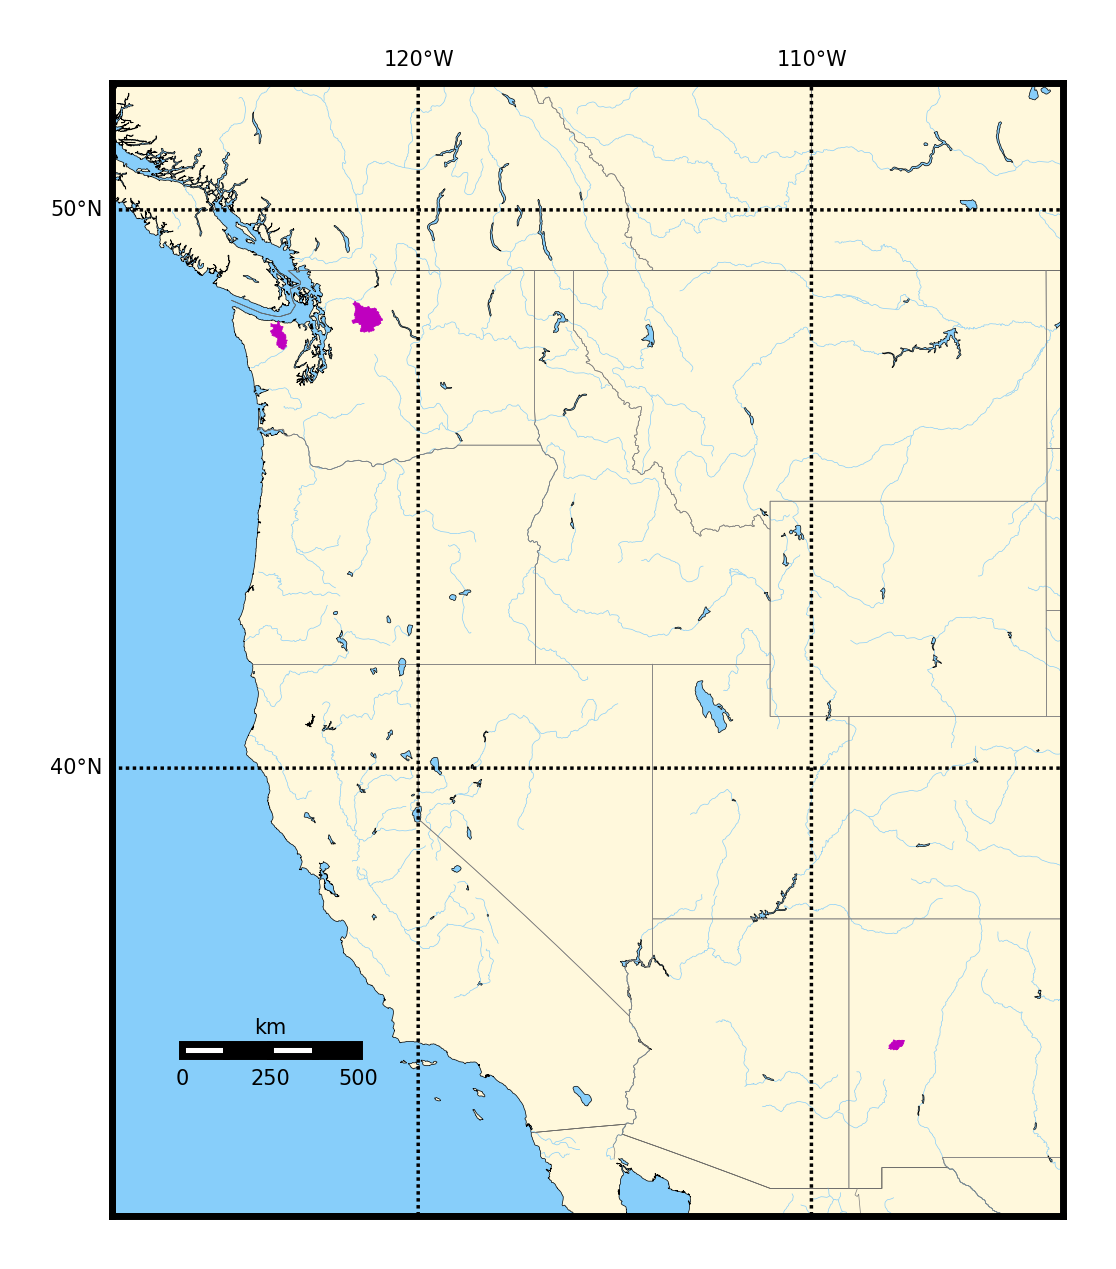

In [9]:
"""
All watersheds

shape_path: (dir) the path to the watershed ESRI shapefile without the .shp suffix
espg: (int) the epsg map projection
polygon_color: (str) the name or single-letter code for the color of the watershed polygons
map_margins: (float) the multiplier for the map margins outside of the watershed bounding box

"""

shape_path = os.path.join(homedir, 'allwatersheds')
epsg = 3857
polygon_color = 'm' # magenta
map_margin = 0.25 # 25% of width and height dimensions
mapscaleloc = 'botleft'


# generate the figure axis
fig = plt.figure(figsize=(3,3), dpi=500)
ax1 = plt.subplot2grid((1,1),(0,0))

# normalize the color distribution according to the value distribution
cmap = mpl.cm.gnuplot2

# calculate bounding box based on the watershed shapefile
watershed = fiona.open(shape_path+'.shp')
minx, miny, maxx, maxy = watershed.bounds
w, h = maxx - minx, maxy - miny
watershed.close()

# generate basemap
m = Basemap(projection='merc', epsg=epsg, resolution='h', ax=ax1,
            llcrnrlon=minx - map_margin*w, llcrnrlat=miny - map_margin*h, 
            urcrnrlon=maxx + map_margin*w, urcrnrlat=maxy + map_margin*h)

# affix boundaries
m.drawcountries(linewidth=0.1)
m.drawcoastlines(linewidth=0.1)
m.drawmapboundary(fill_color='lightskyblue')
m.fillcontinents(color='cornsilk', lake_color='lightskyblue')
m.drawrivers(color='lightskyblue', linewidth=0.1)
m.drawstates(linewidth=0.1, linestyle='solid', color='gray')
m.drawcountries(color='gray', linewidth=0.1)

# draw distance scale
# length = round(w*50,-2)
# yoffset = w*1000
# m.drawmapscale(minx, miny-0.5*map_margin*h, maxx, maxy, length, yoffset=yoffset, barstyle='fancy', fontsize=3, linewidth=0)
m.drawmapscale(minx, miny, maxx, maxy, 500, yoffset=35000, barstyle='fancy', fontsize=3, linewidth=0)

# draw cardinal markers
m.drawparallels(np.arange(10,70,10),labels=[1,0,0,0], fontsize=3, color='black', linewidth=0.5)
m.drawmeridians(np.arange(-160,0,10),labels=[0,0,1,0], fontsize=3, color='black', linewidth=0.5)

# read and transform the watershed shapefiles
m.readshapefile(shapefile = shape_path, name='allwatersheds', linewidth=0)

# load and transform each polygon in shape
patches = [PolygonPatch(Polygon(np.array(shape)), fc=polygon_color, ec=polygon_color, linewidth=0.1, zorder=5.0) 
           for info, shape in zip(m.allwatersheds_info, m.allwatersheds)]

# assimilate shapes to plot axis
coll = PatchCollection(patches, cmap=cmap, match_original=True, zorder=5.0)
ax1.add_collection(coll)

plt.savefig(os.path.join(homedir, 'statemap.png'), dpi=500)
plt.show()

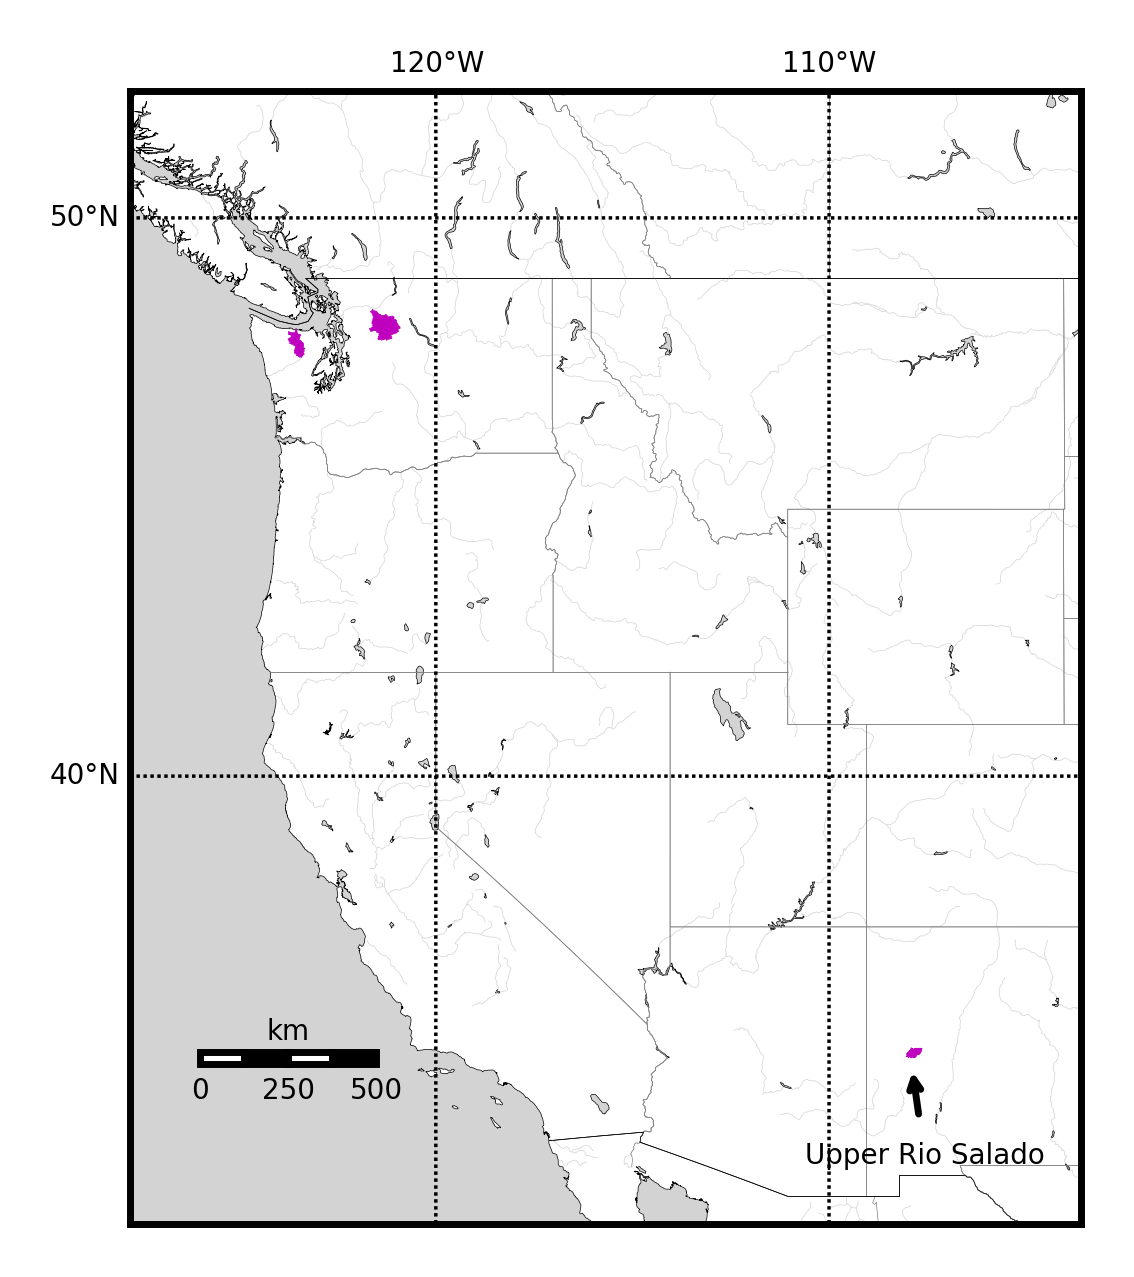

CPU times: user 20.6 s, sys: 1.22 s, total: 21.8 s
Wall time: 20.4 s


In [10]:
%%time
"""
All watersheds, annotated

shape_path: (dir) the path to the watershed ESRI shapefile without the .shp suffix
espg: (int) the epsg map projection
polygon_color: (str) the name or single-letter code for the color of the watershed polygons
map_margins: (float) the multiplier for the map margins outside of the watershed bounding box
"""

shape_path = os.path.join(homedir, 'allwatersheds')
epsg = 3857
polygon_color = 'm' # magenta
map_margin = 0.25 # percent of width and height dimensions
mapscaleloc = 'botleft'

# generate the figure axis
fig = plt.figure(figsize=(3,3), dpi=500)
ax1 = plt.subplot2grid((1,1),(0,0))

# normalize the color distribution according to the value distribution
cmap = mpl.cm.gnuplot2

# calculate bounding box based on the watershed shapefile
watershed = fiona.open(shape_path+'.shp')
minx, miny, maxx, maxy = watershed.bounds
w, h = maxx - minx, maxy - miny
watershed.close()

# generate basemap
m = Basemap(projection='merc', epsg=epsg, resolution='h', ax=ax1,
            llcrnrlon=minx - map_margin*w, llcrnrlat=miny - map_margin*h, 
            urcrnrlon=maxx + map_margin*w, urcrnrlat=maxy + map_margin*h)

# affix boundaries
m.drawcountries(linewidth=0.1)
m.drawcoastlines(linewidth=0.1)
m.drawmapboundary(fill_color='lightgray')
m.fillcontinents(color='white', lake_color='lightgray')
m.drawrivers(linewidth=0.1, color='lightgray', )
m.drawstates(linewidth=0.1, color='gray', linestyle='solid')
m.drawcountries(linewidth=0.1, color='black')

# draw cardinal markers
m.drawparallels(np.arange(10,70,10),labels=[1,0,0,0], fontsize=4, color='black', linewidth=0.5)
m.drawmeridians(np.arange(-160,0,10),labels=[0,0,1,0], fontsize=4, color='black', linewidth=0.5)

# read and transform the watershed shapefiles
m.readshapefile(shapefile = shape_path, name='allwatersheds', linewidth=0)
m.readshapefile(shapefile = os.path.join(homedir, 'eachwatershed'), 
                name='eachwatershed', linewidth=0)

# load and transform each polygon in shape
patches = [PolygonPatch(Polygon(np.array(shape)), fc=polygon_color, ec=polygon_color, linewidth=0.1, zorder=5.0) 
           for info, shape in zip(m.allwatersheds_info, m.allwatersheds)]

# assimilate shapes to plot axis
coll = PatchCollection(patches, cmap=cmap, match_original=True, zorder=5.0)
ax1.add_collection(coll)

# parameters annotated based on non-cyl projections
if epsg!=4326:
    
    # draw distance scale
    m.drawmapscale(minx, miny, maxx, maxy, 500, yoffset=35000, barstyle='fancy', fontsize=4, linewidth=0)
    #     if h>w:
    #         length = round(w*100,-2)
    #         yoffset = w*1000
    #     else:
    #         length = round(h*100,-2)
    #         yoffset = h*1000

    #     if mapscaleloc=='botleft':
    #         m.drawmapscale(minx, miny-0.5*map_margin*h, maxx, maxy, length, yoffset=yoffset, barstyle='fancy', fontsize=3, linewidth=0)
    #     elif mapscaleloc=='botright':
    #         m.drawmapscale(maxx, miny-0.5*map_margin*h, maxx, maxy, length, yoffset=yoffset, barstyle='fancy', fontsize=3, linewidth=0)

    for eachinfo, eachpoly in zip(m.eachwatershed_info, m.eachwatershed):
        if (eachinfo['RINGNUM']==1) & (eachinfo['watershed']=='Sauk-Suiattle'):
            plt.annotate(eachinfo['watershed'], fontsize=4,
                         arrowprops=dict(arrowstyle="->"),
                         xy=np.array(Polygon(eachpoly).centroid), 
                         xytext=np.array(Polygon(eachpoly).centroid)+[0,-300000])
            
        if (eachinfo['RINGNUM']==1)&(eachinfo['watershed'] in ('Elwha','Upper Rio Salado')):
            plt.annotate(eachinfo['watershed'], fontsize=4,
                         arrowprops=dict(arrowstyle="->"),
                         xy=np.array(Polygon(eachpoly).centroid), 
                         xytext=np.array(Polygon(eachpoly).centroid)+[-300000,-300000])
            
plt.savefig(os.path.join(homedir, 'statemap_annotated.png'), dpi=500)
plt.show()

In [20]:
%%time 
# Generate list of stations to download
mappingfile1=ogh.treatgeoself(shapefile=sauk, NAmer=NAmer, buffer_distance=0.06, 
                              mappingfile=os.path.join(os.getcwd(),'Sauk_mappingfile.csv'))
print(mappingfile1)


mappingfile2=ogh.treatgeoself(shapefile=elwha, NAmer=NAmer, buffer_distance=0.06, 
                              mappingfile=os.path.join(os.getcwd(),'Elwha_mappingfile.csv'))
print(mappingfile2)


mappingfile3=ogh.treatgeoself(shapefile=riosalado, NAmer=NAmer, buffer_distance=0.06, 
                              mappingfile=os.path.join(os.getcwd(),'RioSalado_mappingfile.csv'))
print(mappingfile3)

CPU times: user 1.29 ms, sys: 97 µs, total: 1.38 ms
Wall time: 1.39 ms


 ## 3. Download climate data 

### Get Daily Meteorologic Data (1915-2011) from Livneh et al. 2013 

The functions used in this section apply to hydrometeorology data within the Continental United States with daily data 1915-2011. <br/>
View data extent at  Livneh, B. (2017). Gridded climatology locations (1/16th degree): Continental United States extent, HydroShare, http://www.hydroshare.org/resource/14f0a6619c6b45cc90d1f8cabc4129af

Please cite: <br/>
Livneh B., E.A. Rosenberg, C. Lin, B. Nijssen, V. Mishra, K.M. Andreadis, E.P. Maurer, and D.P. Lettenmaier, 2013: A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States: Update and Extensions, Journal of Climate, 26, 9384–9392.<br/>
<br/>
The getClimateData_DailyMET_livneh2013() function reads in the mapping file table, downloads, and unzips the data files for each of the longitude and latitude points. The folder containing the data is within the directory listed as homedir. 

### Get Meteorologic climate data (1950-2013) from Livneh et al. 2015

The functions used in this section apply to hydrometeorology data is within the North America area with daily data 1950-2013. View the data extent from this HydroShare resource: Livneh, B. (2017). Gridded climatology locations (1/16th degree): North American extent, HydroShare,  http://www.hydroshare.org/resource/ef2d82bf960144b4bfb1bae6242bcc7f

Please cite: <br/>
Livneh B., T.J. Bohn, D.S. Pierce, F. Munoz-Ariola, B. Nijssen, R. Vose, D. Cayan, and L.D. Brekke, 2015: A spatially comprehensive, hydrometeorological data set for Mexico, the U.S., and southern Canada 1950-2013, Nature Scientific Data, 5:150042, doi:10.1038/sdata.2015.42.<br/>
<br/>
The getClimateData_DailyMET_livneh2015() function reads in the mapping file table, downloads, and unzips the data files for each of the longitude and latitude points. The folder containing the data is within the directory listed as homedir. 



### Get the raw and bias corrected Daily Weather Research and Forecasting (WRF 1950-2010 Pacific Northwest) from Salathe et al., 2014
<br/>
Please cite 2014 data using: <br/>
Salathé, EP, AF Hamlet, CF Mass, M Stumbaugh, S-Y Lee, R Steed: 2017. Estimates of 21st Century Flood Risk in the Pacific Northwest Based on Regional Scale Climate Model Simulations.  J. Hydrometeorology. DOI: 10.1175/JHM-D-13-0137.1

This data is also available on HydroShare and can be downloaded using the following line of code (copy into code block):
hs.getResourceFromHydroShare('0db969e4cfb54cb18b4e1a2014a26c82')


In [ ]:
ogh.getDailyMET_livneh2013(homedir, mappingfile1)
ogh.getDailyMET_bcLivneh2013(homedir, mappingfile1)
ogh.getDailyMET_livneh2015(homedir, mappingfile1)
ogh.getDailyVIC_livneh2013(homedir, mappingfile1)
ogh.getDailyVIC_livneh2015(homedir, mappingfile1)
ogh.getDailyWRF_salathe2014(homedir, mappingfile1)
ogh.getDailyWRF_bcsalathe2014(homedir, mappingfile1)

In [ ]:
ogh.getDailyMET_livneh2013(homedir, mappingfile2)
ogh.getDailyMET_bcLivneh2013(homedir, mappingfile2)
ogh.getDailyMET_livneh2015(homedir, mappingfile2)
ogh.getDailyVIC_livneh2013(homedir, mappingfile2)
ogh.getDailyVIC_livneh2015(homedir, mappingfile2)
ogh.getDailyWRF_salathe2014(homedir, mappingfile2)
ogh.getDailyWRF_bcsalathe2014(homedir, mappingfile2)

In [ ]:
ogh.getDailyMET_livneh2013(homedir, mappingfile3)
ogh.getDailyMET_bcLivneh2013(homedir, mappingfile3)
ogh.getDailyMET_livneh2015(homedir, mappingfile3)
ogh.getDailyVIC_livneh2013(homedir, mappingfile3)
ogh.getDailyVIC_livneh2015(homedir, mappingfile3)
ogh.getDailyWRF_salathe2014(homedir, mappingfile3)
ogh.getDailyWRF_bcsalathe2014(homedir, mappingfile3)

In [ ]:
def mappingfileSummary(listofmappingfiles, listofwatershednames, meta_file):
    """
    Generate Data Availability Table for all mappingfile summaries
    
    listofmappingfiles: (list) path directories to the mappingfile for each watershed to be compared
    listofwatershednames: (list) strings for the name of each watershed
    """
    datainventory = []
    
    # loop each mappingfile
    for mappingfile, watershedname in zip(listofmappingfiles, listofwatershednames):
        mapdf = pd.read_csv(mappingfile)
        
        # summarize the total dimensions
        tmp=[]
        tmp.append(tuple(['Watershed',watershedname]))
        tmp.append(tuple(['Median elevation in meters [range](No. gridded cells)',
                          '{0}[{1}-{2}] (n={3})'.format(int(mapdf.ELEV.median()),
                                                        int(mapdf.ELEV.min()), 
                                                        int(mapdf.ELEV.max()),
                                                        int(len(mapdf)))]))
        
        # summarize for each gridded data product
        for each in mapdf.columns:
            if each in meta_file.keys():
                filesobtained = mapdf[mapdf[each].apply(lambda x: pd.notnull(x))].reset_index()
                if len(filesobtained)>0:
                    tmp.append(tuple([each, 
                                      '{0}[{1}-{2}] (n={3})'.format(int(filesobtained.ELEV.median()), 
                                                                    int(filesobtained.ELEV.min()), 
                                                                    int(filesobtained.ELEV.max()), 
                                                                    int(filesobtained[each].count()))]))

        # interpret list to table form
        t1 = pd.DataFrame.from_records(tmp, 
                                       columns=['datasets','values']).set_index('datasets').T.set_index(['Watershed',
                                                                                                              'Median elevation in meters [range](No. gridded cells)'])

        # compile into summary table
        if len(datainventory)==0:
            datainventory=t1.copy()
        else:
            datainventory=pd.concat([datainventory, t1], axis=0)
    
    # conform into datasets by watershed summary
    datainventory = datainventory.T.fillna(0)
    datainventory.index.name = None
    return(datainventory)

In [ ]:
t2 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1, mappingfile2, mappingfile3], 
                            listofwatershednames = ['Sauk-Suiattle river','Elwha river','Upper Rio Salado'],
                            meta_file=meta_file)

t2

In [ ]:
ogh.griddedCellGradient(mappingfile=mappingfile1, 
                        shapefile=sauk.replace('.shp','_2.shp'),
                        spatial_resolution=1/16,
                        margin=0.25,
                        epsg=3857,
                        column='ELEV',
                        plottitle='Sauk-Suiattle river watershed'+'\nGridded cell elevation gradient',
                        colorbar_label='Average elevation (meters)',
                        cmap='seismic_r',
                        outfilepath=os.path.join(homedir, 'gcGradient_s.png'))

ogh.griddedCellGradient(mappingfile=mappingfile2, 
                        shapefile=elwha.replace('.shp','_2.shp'),
                        spatial_resolution=1/16,
                        margin=0.25,
                        epsg=3857,
                        column='ELEV',
                        plottitle='Elwha river watershed'+'\nGridded cell elevation gradient',
                        colorbar_label='Average elevation (meters)',
                        cmap='seismic_r',
                        outfilepath=os.path.join(homedir, 'gcGradient_e.png'))

ogh.griddedCellGradient(mappingfile=mappingfile3, 
                        shapefile=riosalado.replace('.shp','_2.shp'),
                        spatial_resolution=1/16,
                        margin=0.5,
                        epsg=3857,
                        column='ELEV',
                        plottitle='Rio Salado watershed'+'\nGridded cell elevation gradient',
                        colorbar_label='Average elevation (meters)',
                        cmap='seismic_r',
                        outfilepath=os.path.join(homedir, 'gcGradient_r.png'))

## 4.  Compare Hydrometeorology 

This section performs computations and generates plots of the Livneh 2013, Livneh 2016, and WRF 2014 temperature and precipitation data in order to compare them with each other and observations. The generated plots are automatically downloaded and saved as .png files in the "plots" folder of the user's home directory and inline in the notebook.

### INPUT: Location Name and watershed drainage area (m2)

    location name                       = Sauk Watershed <br/>
    streamflow watershed drainage area  = 1849242318 sq meters

In [ ]:
# livneh 2013
dr1 = meta_file['dailymet_livneh2013']

# livneh 2014
dr2 = meta_file['dailywrf_salathe2014']

# define overlapping time window
dr = ogh.overlappingDates(date_set1=tuple([dr1['start_date'], dr1['end_date']]), 
                          date_set2=tuple([dr2['start_date'], dr2['end_date']]))
dr

### INPUT: gridded meteorology from Jupyter Hub folders
Data frames for each set of data are stored in a dictionary. The inputs to gridclim_dict() include the folder location and name of the hydrometeorology data, the file start and end, the analysis start and end, and the elevation band to be included in the analsyis (max and min elevation). <br/>  

#### Create a dictionary of climate variables for the long-term mean (ltm) using the default elevation option of calculating a high, mid, and low elevation average.  The dictionary here is initialized with the Livneh et al., 2013 dataset with a dictionary output 'ltm_3bands', which is used as an input to the second time we run gridclim_dict(), to add the Salathe et al., 2014 data to the same dictionary. 

In [ ]:
%%time

ltm_3bands = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset='dailymet_livneh2013',
                               file_start_date=dr1['start_date'], 
                               file_end_date=dr1['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1])

In [ ]:
%%time
ops =[]


month=3
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_3bands['month_PRECIP_dailymet_livneh2013'],
                     vardf_dateindex=month,
                     shapefile=sauk.replace('.shp','_2.shp'), 
                     outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                     plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                     colorbar_label='Average monthly precipitation (meters)',
                     spatial_resolution=1/16, margin=0.5, epsg=3857,
                     basemap_image='Demographics/USA_Social_Vulnerability_Index',
                     cmap='gray_r')

month=6
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_3bands['month_PRECIP_dailymet_livneh2013'],
                     vardf_dateindex=month,
                     shapefile=sauk.replace('.shp','_2.shp'), 
                     outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                     plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                     colorbar_label='Average monthly precipitation (meters)',
                     spatial_resolution=1/16, margin=0.5, epsg=3857,
                     basemap_image='ESRI_StreetMap_World_2D',
                     cmap='gray_r')

month=9
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_3bands['month_PRECIP_dailymet_livneh2013'],
                     vardf_dateindex=month,
                     shapefile=sauk.replace('.shp','_2.shp'), 
                     outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                     plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                     colorbar_label='Average monthly precipitation (meters)',
                     spatial_resolution=1/16, margin=0.5, epsg=3857,
                     basemap_image='ESRI_Imagery_World_2D',
                     cmap='gray_r')

month=12
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_3bands['month_PRECIP_dailymet_livneh2013'],
                     vardf_dateindex=month,
                     shapefile=sauk.replace('.shp','_2.shp'), 
                     outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                     plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                     colorbar_label='Average monthly precipitation (meters)',
                     spatial_resolution=1/16, margin=0.5, epsg=3857,
                     basemap_image='Elevation/World_Hillshade',
                     cmap='gray_r')


## comparison to WRF data from Salathe et al., 2014

In [ ]:
%%time
ltm_3bands = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset='dailywrf_salathe2014',
                               file_start_date=dr2['start_date'], 
                               file_end_date=dr2['end_date'],
                               file_time_step=dr2['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_3bands)

# 5. Download gridded hydrology

In [ ]:
def renderValuesInPoints(vardf,
                         vardf_dateindex,
                         shapefile=sauk.replace('.shp','_2.shp'), 
                         spatial_resolution=1/16,
                         margin=0.5,
                         crs={'init':'epsg:3857'},
                         vmin=None,
                         vmax=None,
                         epsg=3857,
                         basemap_image='Canvas/World_Dark_Gray_Base',
                         cmap='coolwarm',
                         plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in November',
                         colorbar_label='Average monthly precipitation (meters)',
                         outfilepath=os.path.join(homedir, 'SaukNovPrecip.png')):

    # generate the figure axis
    fig = plt.figure(figsize=(2,2), dpi=500)
    ax1 = plt.subplot2grid((1,1),(0,0))

    # generate the polygon color-scheme
    cmap = mpl.cm.get_cmap(cmap)
    

    norm = mpl.colors.Normalize(vardf.values.flatten().min(), vardf.values.flatten().max())
    color_producer = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    # calculate bounding box based on the watershed shapefile
    watershed = fiona.open(shapefile)
    minx, miny, maxx, maxy = watershed.bounds
    w, h = maxx - minx, maxy - miny
    watershed.close()
    
    # generate basemap
    m = Basemap(projection='merc', epsg=epsg,
                llcrnrlon=minx - margin*w, llcrnrlat=miny - margin*h, 
                urcrnrlon=maxx + margin*w, urcrnrlat=maxy + margin*h,
                resolution='l', ax=ax1)
    m.arcgisimage(service=basemap_image, xpixels=500)
                         
    # watershed
    m.readshapefile(shapefile=shapefile.replace('.shp',''), name='watershed', drawbounds=True, color='m')
    
    # variable dataframe
    midpt=spatial_resolution/2
    cat=vardf.T.reset_index(level=[1,2]).rename(columns={'level_1':'LAT','level_2':'LONG_'})
    geometry = cat.apply(lambda x: shapely.ops.transform(m, box(x['LONG_']-midpt, x['LAT']-midpt, 
                                                                x['LONG_']+midpt, x['LAT']+midpt)), axis=1)
    cat2 = gpd.GeoDataFrame(cat, crs=crs, geometry=geometry).reset_index(drop=True)

    # geopandas print
    cat2.plot(column=vardf_dateindex, cmap=cmap, alpha=0.4, ax=ax1,
              vmin=vardf.values.flatten().min(), vmax=vardf.values.flatten().max())

    # assimilate the shapes to plot
    patches = []
    for ind, eachpol in cat2.iterrows():
        patches.append(PolygonPatch(eachpol['geometry'], linewidth=0, zorder=5.0,
                                    fc=color_producer.to_rgba(eachpol[vardf_dateindex])))

    # assimilate shapes into a patch collection
    coll = PatchCollection(patches, cmap=cmap, match_original=True, zorder=10.0)
    #ax1.add_collection(coll)
    
    # generate colorbar
    coll.set_array(vardf.values.flatten())
    coll.set_clim([vardf.as_matrix().min(), vardf.as_matrix().max()])
    cbar = plt.colorbar(coll, shrink=0.5)
    cbar.ax.set_ylabel(colorbar_label, rotation=270, size=3, labelpad=5) # colorbar label
    cbar.ax.tick_params(labelsize=3) # colorbar tick fontsize

    # name the plot
    plt.title(plottitle, fontsize=3)
    
    # save image
    plt.savefig(outfilepath)
    plt.show()

In [ ]:
for month, outfile in zip(range(1,13),
                          ['SaukJanPrecip.png','SaukFebPrecip.png','SaukMarPrecip.png','SaukAprPrecip.png',
                           'SaukMayPrecip.png','SaukJunPrecip.png','SaukJulPrecip.png','SaukAugPrecip.png',
                           'SaukSepPrecip.png','SaukOctPrecip.png','SaukNovPrecip.png','SaukDecPrecip.png']):
    monthlabel = pd.datetime.strptime(str(month), '%m').strftime('%B')
    
    ax1 = renderValuesInPoints(vardf=ltm_3bands['month_PRECIP_dailymet_livneh2013'],
                           vardf_dateindex=month,
                           shapefile=sauk.replace('.shp','_2.shp'), 
                           basemap_image='ESRI_Imagery_World_2D',
                           cmap='jet_r',
                           plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel,
                           colorbar_label='Average monthly precipitation (meters)',
                           outfilepath=os.path.join(homedir, outfile))

In [ ]:
%%time
axis1 = ogh.renderPointsInShape(shapefile=sauk.replace('.shp','_2.shp'),
                                NAmer=NAmer,
                                mappingfile=mappingfile1,
                                colvar=['dailymet_livneh2013', 'dailywrf_salathe2014'])

In [ ]:
def plot_meanTmin(dictionary, loc_name, start_date, end_date):
    # Plot 1: Monthly temperature analysis of Livneh data
    if 'meanmonth_temp_min_liv2013_met_daily' and 'meanmonth_temp_min_wrf2014_met_daily' not in dictionary.keys():
        pass

    # generate month indices
    wy_index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    wy_numbers=[10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    month_strings=[ 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept']
    
    # initiate the plot object
    fig, ax=plt.subplots(1,1,figsize=(10, 6))

    if 'meanmonth_temp_min_liv2013_met_daily' in dictionary.keys():
        # Liv2013

        plt.plot(wy_index, dictionary['meanmonth_temp_min_liv2013_met_daily'][wy_numbers],'r-', linewidth=1, label='Liv Temp min')  
    
    if 'meanmonth_temp_min_wrf2014_met_daily' in dictionary.keys():
        # WRF2014
        plt.plot(wy_index, dictionary['meanmonth_temp_min_wrf2014_met_daily'][wy_numbers],'b-',linewidth=1, label='WRF Temp min')
 
    if 'meanmonth_temp_min_livneh2013_wrf2014bc_met_daily' in dictionary.keys():
        # WRF2014
        plt.plot(wy_index, dictionary['meanmonth_temp_min_livneh2013_wrf2014bc_met_daily'][wy_numbers],'g-',linewidth=1, label='WRFbc Temp min')
 
    # add reference line at y=0
    plt.plot([1, 12],[0, 0], 'k-',linewidth=1)

    plt.ylabel('Temp (C)',fontsize=14)
    plt.xlabel('Month',fontsize=14)
    plt.xlim(1,12);
    plt.xticks(wy_index, month_strings);
        
    plt.tick_params(labelsize=12)
    plt.legend(loc='best')
    plt.grid(which='both')
    plt.title(str(loc_name)+'\nMinimum Temperature\n Years: '+str(start_date.year)+'-'+str(end_date.year)+'; Elevation: '+str(dictionary['analysis_elev_min'])+'-'+str(dictionary['analysis_elev_max'])+'m', fontsize=16)
    plt.savefig('monthly_Tmin'+str(loc_name)+'.png')
    plt.show()

# 6. Compare gridded model to point observations

### Read in  SNOTEL data - assess available data 
If you want to plot observed snotel point precipitation or temperature with the gridded climate data, set to 'Y' 
Give name of Snotel file and name to be used in figure legends. 
File format: Daily SNOTEL Data Report - Historic - By individual SNOTEL site, standard sensors (https://www.wcc.nrcs.usda.gov/snow/snotel-data.html)

In [ ]:
# Sauk
SNOTEL_file = os.path.join(homedir,'ThunderBasinSNOTEL.txt')
SNOTEL_station_name='Thunder Creek'
SNOTEL_file_use_colsnames = ['Date','Air Temperature Maximum (degF)', 'Air Temperature Minimum (degF)','Air Temperature Average (degF)','Precipitation Increment (in)']
SNOTEL_station_elev=int(4320/3.281) # meters

SNOTEL_obs_daily = ogh.read_daily_snotel(file_name=SNOTEL_file, 
                                         usecols=SNOTEL_file_use_colsnames,
                                         delimiter=',', 
                                         header=58)

# generate the start and stop date
SNOTEL_obs_start_date=SNOTEL_obs_daily.index[0]
SNOTEL_obs_end_date=SNOTEL_obs_daily.index[-1]

# peek
SNOTEL_obs_daily.head(5)

### Read in  COOP station data - assess available data
https://www.ncdc.noaa.gov/

In [ ]:
COOP_file=os.path.join(homedir, 'USC00455678.csv') # Sauk
COOP_station_name='Mt Vernon'
COOP_file_use_colsnames = ['DATE','PRCP','TMAX', 'TMIN','TOBS']
COOP_station_elev=int(4.3) # meters

COOP_obs_daily = ogh.read_daily_coop(file_name=COOP_file,
                                     usecols=COOP_file_use_colsnames,
                                     delimiter=',',
                                     header=0)

# generate the start and stop date
COOP_obs_start_date=COOP_obs_daily.index[0]
COOP_obs_end_date=COOP_obs_daily.index[-1]

# peek
COOP_obs_daily.head(5)

In [ ]:
#initiate new dictionary with original data
ltm_0to3000 = ogh.gridclim_dict(metadata=meta_file,
                                mappingfile=mappingfile1,
                                dataset='dailymet_livneh2013',
                                file_start_date=dr1['start_date'], 
                                file_end_date=dr1['end_date'], 
                                subset_start_date=dr[0],
                                subset_end_date=dr[1])

ltm_0to3000 = ogh.gridclim_dict(metadata=meta_file,
                                mappingfile=mappingfile1,
                                dataset='dailywrf_salathe2014',
                                file_start_date=dr2['start_date'], 
                                file_end_date=dr2['end_date'], 
                                subset_start_date=dr[0],
                                subset_end_date=dr[1],
                                df_dict=ltm_0to3000)

sorted(ltm_0to3000.keys())

In [ ]:
# read in the mappingfile
mappingfile = mappingfile1

mapdf = pd.read_csv(mappingfile)

# select station by first FID
firstStation = ogh.findStationCode(mappingfile=mappingfile, colvar='FID', colvalue=0)

# select station by elevation
maxElevStation = ogh.findStationCode(mappingfile=mappingfile, colvar='ELEV', colvalue=mapdf.loc[:,'ELEV'].max())
medElevStation = ogh.findStationCode(mappingfile=mappingfile, colvar='ELEV', colvalue=mapdf.loc[:,'ELEV'].median())
minElevStation = ogh.findStationCode(mappingfile=mappingfile, colvar='ELEV', colvalue=mapdf.loc[:,'ELEV'].min())


# print(firstStation, mapdf.iloc[0].ELEV)
# print(maxElevStation, mapdf.loc[:,'ELEV'].max())
# print(medElevStation, mapdf.loc[:,'ELEV'].median())
# print(minElevStation, mapdf.loc[:,'ELEV'].min())

# let's compare monthly averages for TMAX using livneh, salathe, and the salathe-corrected livneh
comp = ['month_TMAX_dailymet_livneh2013',
        'month_TMAX_dailywrf_salathe2014']

obj = dict()
for eachkey in ltm_0to3000.keys():
    if eachkey in comp:
        obj[eachkey] = ltm_0to3000[eachkey]

panel_obj = pd.Panel.from_dict(obj)
panel_obj

In [ ]:
comp = ['meanmonth_TMAX_dailymet_livneh2013',
        'meanmonth_TMAX_dailywrf_salathe2014']

obj = dict()
for eachkey in ltm_0to3000.keys():
    if eachkey in comp:
        obj[eachkey] = ltm_0to3000[eachkey]

        df_obj = pd.DataFrame.from_dict(obj)
df_obj

In [ ]:
t_res, var, dataset, pub = each.rsplit('_',3)

print(t_res, var, dataset, pub)

In [ ]:
ylab_var = meta_file['_'.join([dataset, pub])]['variable_info'][var]['desc']
ylab_unit = meta_file['_'.join([dataset, pub])]['variable_info'][var]['units']

print('{0} {1} ({2})'.format(t_res, ylab_var, ylab_unit))

In [ ]:
%%time
comp = [['meanmonth_TMAX_dailymet_livneh2013','meanmonth_TMAX_dailywrf_salathe2014'],
        ['meanmonth_PRECIP_dailymet_livneh2013','meanmonth_PRECIP_dailywrf_salathe2014']]
wy_numbers=[10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
month_strings=[ 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']


fig = plt.figure(figsize=(20,5), dpi=500)

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)


# monthly
for eachsumm in df_obj.columns:
    ax1.plot(df_obj[eachsumm])
    

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2, fontsize=10)
plt.show()

In [ ]:
df_obj[each].index.apply(lambda x: x+2)

In [ ]:
fig, ax = plt.subplots()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    panel_obj.xs(key=(minElevStation[0][0], minElevStation[0][1], minElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
fig.show()
    

    
    
fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    panel_obj.xs(key=(maxElevStation[0][0], maxElevStation[0][1], maxElevStation[0][2]), 
                 axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
fig.show()

## Set up VIC dictionary (as an example)  to compare to available data

In [ ]:
vic_dr1 = meta_file['dailyvic_livneh2013']['date_range']
vic_dr2 = meta_file['dailyvic_livneh2015']['date_range']
vic_dr = ogh.overlappingDates(tuple([vic_dr1['start'], vic_dr1['end']]),
                              tuple([vic_dr2['start'], vic_dr2['end']]))

vic_ltm_3bands = ogh.gridclim_dict(mappingfile=mappingfile,
                                   metadata=meta_file,
                                   dataset='dailyvic_livneh2013',
                                   file_start_date=vic_dr1['start'], 
                                   file_end_date=vic_dr1['end'],
                                   file_time_step=vic_dr1['time_step'],
                                   subset_start_date=vic_dr[0],
                                   subset_end_date=vic_dr[1])

In [ ]:
sorted(vic_ltm_3bands.keys())

## 10. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

In [ ]:
#execute this cell to list the content of the directory
!ls -lt

Create list of files to save to HydroShare. Verify location and names.

In [ ]:
!tar -zcf {climate2013_tar} livneh2013
!tar -zcf {climate2015_tar} livneh2015
!tar -zcf {wrf_tar} salathe2014

In [ ]:
ThisNotebook='Observatory_Sauk_TreatGeoSelf.ipynb' #check name for consistency
climate2013_tar = 'livneh2013.tar.gz'
climate2015_tar = 'livneh2015.tar.gz'
wrf_tar = 'salathe2014.tar.gz'
mappingfile = 'Sauk_mappingfile.csv'

files=[ThisNotebook, mappingfile, climate2013_tar, climate2015_tar, wrf_tar]

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Results from testing out the TreatGeoSelf utility'
abstract = 'This the output from the TreatGeoSelf utility integration notebook.'
keywords = ['Sauk', 'climate', 'Landlab','hydromet','watershed'] 
rtype = 'genericresource'  

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)